In [1]:
## import pickle
import numpy as np
import matplotlib.pyplot as plt
from data.visualise import grid_psfs, show_psf_axial
from tifffile import imread
import pandas as pd
import seaborn as sns

def load_pickle_file(dpath):
    with open(dpath, 'rb') as f:
        return pickle.load(f)

# # MQ_data     
# stacks = '/home/miguel/Projects/uni/data/smlm_3d/20230601_MQ_celltype/beads_box15/combined/stacks.ome.tif'
# locs = '/home/miguel/Projects/uni/data/smlm_3d/20230601_MQ_celltype/beads_box15/combined/locs.hdf'
# exclude_idx = [5, 7, 11, 14, 22, 24, 26, 27, 28, 31, 32, 35, 37, 38, 40, 45, 50, 51, 54, 68, 69, 71, 72, 82, 87, 89, 91, 98, 102, 108, 109, 112, 113, 115, 116, 121, 122, 123, 127, 129, 131, 132, 133, 138, 141, 144, 150, 151, 154, 161, 167, 169, 170, 172, 178, 179, 181, 182, 184, 185, 186, 187, 190, 200, 201, 205, 206, 210, 214, 219, 221, 224, 226, 230, 233, 234, 235, 236, 237, 243]
# Z_STEP = 20

# FD-deeploc data
stacks = '/home/miguel/Projects/uni/data/smlm_3d/fd-deeploc-data/Astigmatism_beads_stacks_2um/combined/stacks.ome.tif'
locs = '/home/miguel/Projects/uni/data/smlm_3d/fd-deeploc-data/Astigmatism_beads_stacks_2um/combined/locs.hdf'
exclude_idx = []
Z_STEP = 50

all_psfs = imread(stacks)
all_locs = pd.read_hdf(locs, key='locs')

all_psfs = all_psfs[:, :, :, :, np.newaxis]

print(all_psfs.shape, all_psfs.dtype)

# # for i, psf in enumerate(psfs.sum(axis=-1)):
# #     plt.title(str(i))
# #     show_psf_axial(psf)


# # exclude_idx = [0, 5, 7, 12, 22, 26, 32, 35, 38, 40, 45, 50, 51, 54, 68, 69, 71, 72, 82, 87, 89, 91, 98, 102, 108, 109, 112, 113, 115, 116, 121, 122, 123, 124, 127, 129, 131, 132, 133, 138, 141, 144, 150, 151, 154, 161, 167, 169, 170, 172, 178, 179, 181, 182, 184, 185, 186, 187, 190, 200, 201, 205, 206, 210, 214, 219, 221, 224, 226, 230, 233, 234, 235, 236, 237, 243]

# # print('Excluded PSFs \n\n\n\n\n')
# # for i in exclude_idx:
# #     show_psf_axial(psfs[i].mean(axis=-1), str(i))
# #     plt.plot(psfs[i].max(axis=(1,2)))
# #     plt.show()
# # print('End of excluded PSFs \n\n\n\n\n')

# # print(psfs.shape[0])
# # for i in range(psfs.shape[0]):
# #     if i in exclude_idx:
# #         continue
# #     plt.title(str(i))
# #     show_psf_axial(psfs[i].mean(axis=-1))
# #     plt.plot(psfs[i].max(axis=(1,2,3)), label='max')
# #     plt.legend()
# #     plt.title(str(i))
# #     plt.show()

# idx = [i for i in range(psfs.shape[0]) if i not in exclude_idx]
# psfs = psfs[idx]
# locs = locs.iloc[idx]
all_locs['idx'] = np.arange(all_locs.shape[0])


(6259, 201, 15, 15, 1) uint16


In [2]:
# xlim = ((450, 750))
# ylim = ((450, 750))


xlim = ((810, 810+250))
ylim = ((790, 790+250))


idx = (xlim[0] < all_locs['x']) & (all_locs['x'] < xlim[1]) & (ylim[0] < all_locs['y']) & (all_locs['y'] < ylim[1])
locs = all_locs[idx]
psfs = all_psfs[locs['idx']]

print(psfs.shape)

ys = []
for i in range(psfs.shape[0]):
    y = np.arange(psfs.shape[1]) * Z_STEP
    y = y - 1000
    ys.append(y)
ys = np.stack(ys)

(155, 201, 15, 15, 1)


In [3]:
# exclude_idx = [35, 55, 60, 96, 104, 113, 128, 132, 230, 234]
exclude_idx = [0, 82, 109, 114, 138, 141, 149, 153]
# exclude_idx = []
idx = [i for i in range(psfs.shape[0]) if i not in exclude_idx]
psfs = psfs[idx]
locs = locs.iloc[idx]

2023-09-07 09:36:45.501546: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-07 09:36:45.928217: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
0it [00:00, ?it/s]

[1555]


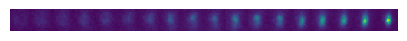

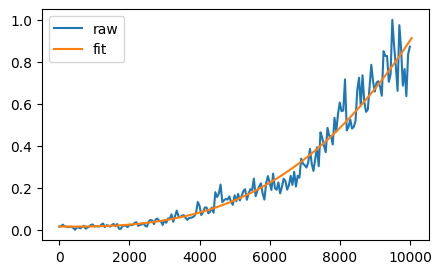

147it [00:00, 922.64it/s]


In [4]:
# Spline peak finding
from tqdm import tqdm
import numpy as np
Z_STEP = 50

from scipy.interpolate import UnivariateSpline
from data.align_psfs import norm_zero_one
from scipy import signal
import cv2
import numpy as np

plt.rcParams['figure.figsize'] = [5, 3]

DEBUG = False

UPSCALE_RATIO = 10

bad_psfs_idx = []

def denoise(img):
    from scipy.ndimage import gaussian_filter
    
    return gaussian_filter(img.copy(), sigma=(2, 1, 1))
    

def find_peak(i, psf):
    if psf.ndim == 4:
        psf = psf.mean(axis=-1)
    x = np.arange(psf.shape[0]) * Z_STEP
#     psf = denoise(psf)
    
    inten = norm_zero_one(psf.max(axis=(1,2)))

    cs = UnivariateSpline(x, inten, k=3, s=1.1)

    x_ups = np.linspace(0, psf.shape[0], len(x) * UPSCALE_RATIO) * Z_STEP

    peak_xups = x_ups[np.argmax(cs(x_ups))] 

    fit = cs(x_ups)
    
    peak = max(fit)
    low = min(fit)
    half_max = (peak - low) / 2
    
    peak_idx = np.argmax(fit)
    center_x = len(x_ups) / 2
    
    half_max_crossings = np.where(np.diff(np.sign(fit-half_max)))[0]
    if len(half_max_crossings) < 2:
        print(half_max_crossings)
        bad_psfs_idx.append(i)
        show_psf_axial(psf)
        plt.plot(x-peak, inten, label='raw')
        plt.plot(x_ups-peak, cs(x_ups), label='fit')
        plt.legend()
        plt.show()
    
    if DEBUG:
        show_psf_axial(psf)
        plt.plot(x-peak, inten, label='raw')
        plt.plot(x_ups-peak, cs(x_ups), label='fit')
        plt.legend()
        plt.show()
    return peak_xups

offsets = np.array([find_peak(i, psf) for i, psf in tqdm(enumerate(psfs))])

good_idx = [i for i in range(len(psfs)) if i not in bad_psfs_idx][0:50]

offsets = offsets[good_idx]
psfs = psfs[good_idx]
locs = locs.iloc[good_idx]


In [5]:

ys = []
for i, offset in enumerate(offsets):
    zs = ((np.arange(psfs.shape[1])) * Z_STEP) -offset
    ys.append(zs)

ys = np.array(ys)


In [6]:
print(psfs.shape)
print(ys.shape)


(50, 201, 15, 15, 1)
(50, 201)


/tmp/ipykernel_784316/1777868043.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  locs['group'][:] = 0


<AxesSubplot:xlabel='x', ylabel='y'>

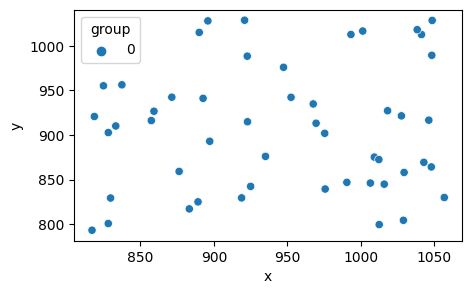

In [9]:
# Stratify according to area of FOV

from sklearn.preprocessing import KBinsDiscretizer
def cart2pol(xy):
    x, y = xy
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(rho, phi)

center = locs[['x', 'y']].mean().to_numpy()
coords = locs[['x', 'y']].to_numpy() - center

polar_coords = np.stack([cart2pol(xy) for xy in coords])

discretizer = KBinsDiscretizer(n_bins=6, encode='ordinal')
groups = discretizer.fit_transform(polar_coords[:, 1:2]).astype(str)

center_radius = 50
idx = np.argwhere(polar_coords[:, 0] <= center_radius).squeeze()
groups[idx] = -1

locs['group'] = groups
sns.scatterplot(data=locs, x='x', y='y', hue='group')


In [10]:
# Withold some PSFs for evaluation

from sklearn.model_selection import train_test_split

SEED = 42

idx = np.arange(psfs.shape[0])

train_idx, test_idx = train_test_split(idx, train_size=0.9, random_state=SEED, stratify=locs['group'])

_train_val_psfs = psfs[train_idx]
test_psfs = psfs[test_idx]

_train_val_ys = ys[train_idx]
test_ys = ys[test_idx]

train_fov_groups = locs['group'].to_numpy()[train_idx]

train_val_coords = locs[['x', 'y']].to_numpy()[train_idx]

# ds_cls = np.zeros((psfs.shape[0]), dtype=object)
# ds_cls[train_idx] = 'train/val'
# ds_cls[test_idx] = 'test'
# locs['ds'] = ds_cls
# sns.scatterplot(data=locs, x='x', y='y', hue='ds')
# plt.show()

In [11]:
_train_val_labels = np.zeros(_train_val_psfs.shape[0:2])
for i in range(_train_val_psfs.shape[0]):
    _train_val_labels[i, :] = i


In [12]:

groups = np.repeat(np.arange(len(train_idx))[:, np.newaxis], psfs.shape[1], axis=1).flatten()

coords = np.repeat(train_val_coords[:, :, np.newaxis], psfs.shape[1], axis=0)

train_val_psfs = np.concatenate(_train_val_psfs)
train_val_labels = np.concatenate(_train_val_labels)

train_val_ys = np.concatenate(_train_val_ys)
split_idx = np.arange(train_val_psfs.shape[0])

train_idx, val_idx = train_test_split(split_idx, train_size=0.9, random_state=SEED, stratify=groups)

train_psfs = train_val_psfs[train_idx]
train_ys = train_val_ys[train_idx][:, np.newaxis]
_train_labels = train_val_labels[train_idx][:, np.newaxis]

val_psfs = train_val_psfs[val_idx]
val_ys = train_val_ys[val_idx][:, np.newaxis]
_val_labels = train_val_labels[val_idx][:, np.newaxis]



In [13]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder().fit(_train_labels)

train_labels = encoder.transform(_train_labels).toarray()
val_labels = encoder.transform(_val_labels).toarray()

print(train_psfs.shape, train_ys.shape, train_labels.shape)
print(val_psfs.shape, val_ys.shape, val_labels.shape)


(8140, 15, 15, 1) (8140, 1) (8140, 45)
(905, 15, 15, 1) (905, 1) (905, 45)


In [14]:
# Trim stacks

def filter_z_range(X, zs):
    psfs, groups = X
    valid_ids = np.argwhere(abs(zs.squeeze()) < Z_RANGE).squeeze()
    return [psfs[valid_ids], groups[valid_ids]], zs[valid_ids]
    
Z_RANGE = 1000
X_train, y_train = filter_z_range((train_psfs, train_labels), train_ys)

X_val, y_val = filter_z_range((val_psfs, val_labels), val_ys)


(1619, 15, 15, 1) 194.0 6749.0 423.3344725825269
Rows 20 Cols 10 n_spaces 200 n_psfs 200
20


2023-09-07 09:39:20.156708: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22142 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6


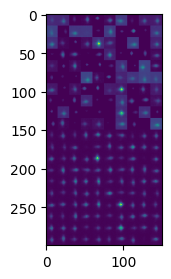

(4857, 15, 15, 1) 194.0 6749.0 592.8292003462382


In [15]:
# data augmentation


from tensorflow.keras import layers, Sequential
from data.visualise import grid_psfs

def aug_dataset(X_train, y_train):
    AUG_RATIO = 2
    MAX_TRANSLATION_PX = 2
    MAX_GAUSS_NOISE = 0.005
    img_size = X_train[0].shape[1]

    aug_pipeline = Sequential([
        layers.GaussianNoise(stddev=MAX_GAUSS_NOISE*X_train[0].max(), seed=SEED),
        layers.RandomTranslation(MAX_TRANSLATION_PX/img_size, MAX_TRANSLATION_PX/img_size, seed=SEED),
        layers.RandomBrightness(0.2, [X_train[0].min(), X_train[0].max()], seed=SEED)
    ])

    idx = np.random.randint(0, X_train[0].shape[0], size=int(AUG_RATIO*X_train[0].shape[0]))

    aug_psfs = aug_pipeline(X_train[0][idx].copy(), training=True).numpy()
    aug_coords = X_train[1][idx]

    aug_z = y_train[idx]

    subset_psfs = np.concatenate((aug_psfs[0:100], X_train[0][idx][0:100]))
    plt.imshow(grid_psfs(subset_psfs.mean(axis=-1)))
    plt.show()

    train_psfs = np.concatenate([aug_psfs, X_train[0]])
    train_coords = np.concatenate([aug_coords, X_train[1]])
    train_zs = np.concatenate([aug_z, y_train])

    X_train = [train_psfs, train_coords]
    y_train = train_zs
    return X_train, y_train

X_train[0] = X_train[0].astype(float)
print(X_train[0].shape, X_train[0].min(), X_train[0].max(), X_train[0].mean())
X_train, y_train = aug_dataset(X_train, y_train)
print(X_train[0].shape, X_train[0].min(), X_train[0].max(), X_train[0].mean())

X_train[0] = X_train[0].astype(np.uint16)

In [16]:
from skimage.transform import resize

def resize_psfs(X):
    print('Resizing...')
    target_size = 128
    imshape = (target_size, target_size, 3)
    X[0] = np.stack([resize(psf, imshape) for psf in X[0]])
    print(X[0].shape)
    print('Finished')

resize_psfs(X_train)
resize_psfs(X_val)

Resizing...
(4857, 128, 128, 3)
Finished
Resizing...
(181, 128, 128, 3)
Finished


In [17]:
print(X_train[0].shape, X_train[1].shape, y_train.shape)
print(X_val[0].shape, X_val[1].shape, y_val.shape)


(4857, 128, 128, 3) (4857, 45) (4857, 1)
(181, 128, 128, 3) (181, 45) (181, 1)


In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1.0/65336.0,
    samplewise_center=False,
    samplewise_std_normalization=False,
    featurewise_center=True,
    featurewise_std_normalization=True,
    horizontal_flip=False)

print('Fitting datagen...')
# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
datagen.fit(X_train[0])
print('Fitted')

X_train_preproc = [X_train[0].copy(), X_train[1].copy()]
X_val_preproc = [X_val[0].copy(), X_val[1].copy()]

X_train_preproc[0] = datagen.standardize(X_train_preproc[0].astype(float))
X_val_preproc[0] = datagen.standardize(X_val_preproc[0].astype(float))

# preprocessors = {
#     'psfs': datagen,
#     'coords': coords_scaler
# }

# import pickle
# with open('./scalers.p', 'wb') as f:
#     pickle.dump(preprocessors, f)

Fitting datagen...
Fitted


In [19]:
test_psfs = psfs[test_idx]

test_ys = ys[test_idx]

test_psfs = np.concatenate(test_psfs)

test_labels = np.zeros((len(test_psfs), train_labels.shape[1]))


test_ys = np.concatenate(test_ys)[:, np.newaxis]
print(test_psfs.shape, test_labels.shape, test_ys.shape)

X_test, y_test = filter_z_range((test_psfs, test_labels), test_ys)

test_groups = X_test[1].copy()


resize_psfs(X_test)
X_test_preproc = [X_test[0].copy(), X_test[1].copy()]
X_test_preproc[0] = datagen.standardize(X_test_preproc[0].astype(float))

print(X_test_preproc[0].shape, X_test_preproc[1].shape, y_test.shape)


(1005, 15, 15, 1) (1005, 45) (1005, 1)
Resizing...
(200, 128, 128, 3)
Finished
(200, 128, 128, 3) (200, 45) (200, 1)


In [20]:
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# X_train_preproc[1] = scaler.fit_transform(X_train_preproc[1])
# X_val_preproc[1] = scaler.transform(X_val_preproc[1])
# X_test_preproc[1] = scaler.transform(X_test_preproc[1])

In [21]:
print(X_train_preproc[0].min(), X_train_preproc[0].max())
print(X_val_preproc[0].min(), X_val_preproc[0].max())
print(X_test_preproc[0].min(), X_test_preproc[0].max())

print(X_train_preproc[1].min(), X_train_preproc[1].max())
print(X_val_preproc[1].min(), X_val_preproc[1].max())
print(X_test_preproc[1].min(), X_test_preproc[1].max())


print(X_train_preproc[0].shape, X_train_preproc[1].shape)
print(X_val_preproc[0].shape, X_val_preproc[1].shape)
print(X_test_preproc[0].shape, X_test_preproc[1].shape)


-0.050914285682845895 1.3352789103243778
-0.05004286694829927 1.153011388713981
-0.04795318038313494 0.8948175890754738
0.0 1.0
0.0 1.0
0.0 0.0
(4857, 128, 128, 3) (4857, 45)
(181, 128, 128, 3) (181, 45)
(200, 128, 128, 3) (200, 45)


In [ ]:
 # Vision transformer training

from tensorflow import keras
from tensorflow.keras import layers, Sequential
from tensorflow.keras import optimizers
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tqdm.keras import TqdmCallback
from tensorflow.keras import regularizers
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, LayerNormalization
from tensorflow.keras.models import Model
from vit_keras import vit

# Assuming your input images have size (image_size, image_size, num_channels)
image_size = X_train_preproc[0].shape[1]
num_channels = X_train_preproc[0].shape[-1]
num_classes = 1  # Regression task, predicting a single continuous value

# Create the Vision Transformer model using the vit_keras library
inputs = Input(shape=(image_size, image_size, num_channels))


vit_model = vit.vit_b16(image_size=image_size, 
                        activation='sigmoid',
                        pretrained=True,
                        include_top=False,
                        pretrained_top=False)

x = vit_model(inputs)
# Add additional layers for regression prediction
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
regression_output = Dense(num_classes, activation='linear')(x)  # Linear activation for regression

labels_input = layers.Input(X_train_preproc[1].shape[1])
x_labels = layers.Dense(1, use_bias=False)(labels_input)

regression_output += x_labels

# Combine the Vision Transformer backbone with the regression head
model = Model(inputs=[inputs, labels_input], outputs=regression_output)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])


batch_size = 64
epochs = 5000
lr = 0.0001

# # Model refining
# model = keras.models.load_model('./latest_vit_model/')
    
# n_layers = len(model.layers)
# for i in range(0, len(model.layers)-4):
#     model.layers[i].trainable = False
# assert model.trainable == True

    
# # Print a summary of the model architecture
# model.summary()


model.compile(loss='mean_squared_error', optimizer=optimizers.AdamW(learning_rate=lr), metrics=['mean_absolute_error'])

callbacks = [
    ReduceLROnPlateau(monitor='val_mean_absolute_error', factor=0.1,
                      patience=50, verbose=True, mode='min', min_delta=5, min_lr=1e-6,),
    EarlyStopping(monitor='val_mean_absolute_error', patience=75,
                  verbose=False, min_delta=1, restore_best_weights=True),
    TqdmCallback(verbose=1),
]


history = model.fit(X_train_preproc, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val_preproc, y_val), callbacks=callbacks, shuffle=True, verbose=True)


/home/miguel/Projects/uni/venv/lib/python3.8/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/home/miguel/Projects/uni/venv/lib/python3.8/site-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 8, 8
  warnings.warn(


Epoch 1/5000


2023-09-07 09:39:58.224772: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8901
2023-09-07 09:39:58.630271: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-09-07 09:39:58.704616: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f6f080195b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-09-07 09:39:58.704627: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2023-09-07 09:39:58.707907: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-09-07 09:39:58.798604: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the p

76/76 [==============================] - 43s 214ms/step - loss: 320647.6562 - mean_absolute_error: 489.5489 - val_loss: 320310.8125 - val_mean_absolute_error: 487.7003 - lr: 1.0000e-04
Epoch 2/5000
76/76 [==============================] - 14s 190ms/step - loss: 285972.0938 - mean_absolute_error: 459.0223 - val_loss: 264986.5312 - val_mean_absolute_error: 434.6597 - lr: 1.0000e-04
Epoch 3/5000
76/76 [==============================] - 15s 192ms/step - loss: 235802.1406 - mean_absolute_error: 408.7699 - val_loss: 197088.9531 - val_mean_absolute_error: 367.7526 - lr: 1.0000e-04
Epoch 4/5000
76/76 [==============================] - 15s 195ms/step - loss: 172464.9531 - mean_absolute_error: 337.5633 - val_loss: 130473.4375 - val_mean_absolute_error: 283.7599 - lr: 1.0000e-04
Epoch 5/5000
76/76 [==============================] - 15s 195ms/step - loss: 121460.2500 - mean_absolute_error: 272.3051 - val_loss: 79274.7422 - val_mean_absolute_error: 213.5156 - lr: 1.0000e-04
Epoch 6/5000
76/76 [====

Epoch 43/5000
76/76 [==============================] - 15s 201ms/step - loss: 44467.8906 - mean_absolute_error: 148.8962 - val_loss: 10101.6123 - val_mean_absolute_error: 76.6326 - lr: 1.0000e-04
Epoch 44/5000
76/76 [==============================] - 15s 201ms/step - loss: 37618.6758 - mean_absolute_error: 138.0036 - val_loss: 15197.5166 - val_mean_absolute_error: 84.6889 - lr: 1.0000e-04
Epoch 45/5000
76/76 [==============================] - 15s 202ms/step - loss: 36777.1367 - mean_absolute_error: 135.4494 - val_loss: 13109.1328 - val_mean_absolute_error: 81.1837 - lr: 1.0000e-04
Epoch 46/5000
76/76 [==============================] - 15s 203ms/step - loss: 42418.3359 - mean_absolute_error: 143.7760 - val_loss: 20927.0957 - val_mean_absolute_error: 105.4507 - lr: 1.0000e-04
Epoch 47/5000
76/76 [==============================] - 15s 202ms/step - loss: 40705.3125 - mean_absolute_error: 143.1751 - val_loss: 13920.1299 - val_mean_absolute_error: 95.3841 - lr: 1.0000e-04
Epoch 48/5000
76/76

Epoch 85/5000
76/76 [==============================] - 15s 203ms/step - loss: 35613.5156 - mean_absolute_error: 129.2872 - val_loss: 12509.6523 - val_mean_absolute_error: 80.6885 - lr: 1.0000e-04
Epoch 86/5000
76/76 [==============================] - 15s 204ms/step - loss: 34748.2227 - mean_absolute_error: 126.9951 - val_loss: 10588.8652 - val_mean_absolute_error: 77.1084 - lr: 1.0000e-04
Epoch 87/5000
76/76 [==============================] - 15s 203ms/step - loss: 33377.6914 - mean_absolute_error: 125.9863 - val_loss: 8371.4678 - val_mean_absolute_error: 63.5266 - lr: 1.0000e-04
Epoch 88/5000
76/76 [==============================] - 15s 203ms/step - loss: 33161.5000 - mean_absolute_error: 124.3750 - val_loss: 10708.1875 - val_mean_absolute_error: 74.8525 - lr: 1.0000e-04
Epoch 89/5000
76/76 [==============================] - 15s 204ms/step - loss: 33643.4922 - mean_absolute_error: 125.9174 - val_loss: 8289.0342 - val_mean_absolute_error: 66.1722 - lr: 1.0000e-04
Epoch 90/5000
76/76 [=

Epoch 126/5000
76/76 [==============================] - 16s 204ms/step - loss: 28938.5605 - mean_absolute_error: 113.7458 - val_loss: 6706.7529 - val_mean_absolute_error: 57.4714 - lr: 1.0000e-05
Epoch 127/5000
76/76 [==============================] - 16s 205ms/step - loss: 28877.1113 - mean_absolute_error: 112.8891 - val_loss: 7728.3901 - val_mean_absolute_error: 60.1147 - lr: 1.0000e-05
Epoch 128/5000
76/76 [==============================] - 16s 205ms/step - loss: 28412.0703 - mean_absolute_error: 112.4411 - val_loss: 6829.4404 - val_mean_absolute_error: 56.1106 - lr: 1.0000e-05
Epoch 129/5000
76/76 [==============================] - 15s 203ms/step - loss: 29692.1289 - mean_absolute_error: 114.8171 - val_loss: 7111.4619 - val_mean_absolute_error: 57.6696 - lr: 1.0000e-05
Epoch 130/5000
76/76 [==============================] - 16s 205ms/step - loss: 28759.3301 - mean_absolute_error: 112.2162 - val_loss: 6779.6597 - val_mean_absolute_error: 55.7613 - lr: 1.0000e-05
Epoch 131/5000
76/76

Epoch 167/5000
76/76 [==============================] - 16s 204ms/step - loss: 28352.3223 - mean_absolute_error: 111.5487 - val_loss: 6462.1846 - val_mean_absolute_error: 54.4967 - lr: 1.0000e-06
Epoch 168/5000
76/76 [==============================] - 16s 205ms/step - loss: 28214.5723 - mean_absolute_error: 110.5320 - val_loss: 6475.1587 - val_mean_absolute_error: 54.7564 - lr: 1.0000e-06
Epoch 169/5000
76/76 [==============================] - 15s 204ms/step - loss: 27153.6699 - mean_absolute_error: 108.2221 - val_loss: 6458.8647 - val_mean_absolute_error: 54.1977 - lr: 1.0000e-06
Epoch 170/5000
76/76 [==============================] - 15s 203ms/step - loss: 28171.9316 - mean_absolute_error: 111.3728 - val_loss: 6551.7568 - val_mean_absolute_error: 55.2955 - lr: 1.0000e-06
Epoch 171/5000
76/76 [==============================] - 16s 205ms/step - loss: 27927.7324 - mean_absolute_error: 110.7758 - val_loss: 6659.4805 - val_mean_absolute_error: 56.0258 - lr: 1.0000e-06
Epoch 172/5000
76/76

In [ ]:
model.save('./latest_vit_model')
print('Fitted model')

In [ ]:
# 227/227 [==============================] - 1s 4ms/step
# train 15.435
# 27/27 [==============================] - 0s 5ms/step
# val 53.627
# 29/29 [==============================] - 0s 5ms/step
# test 94.618


In [ ]:
!ls -la ./latest_vit_model

In [ ]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [5, 5]
fig, ax1 = plt.subplots()
ax1.plot(history.history['mean_absolute_error'], label='mse')
ax1.plot(history.history['val_mean_absolute_error'], label='val_mse')
# ax1.set_ylim([0, 500])
ax1.legend(loc=1)
ax2 = ax1.twinx()
ax2.plot(history.history['lr'], label='lr', color='red')
ax2.legend(loc=0)


In [ ]:
from sklearn.metrics import mean_absolute_error
ds = [
    ('train', (X_train_preproc, y_train)), 
    ('val', (X_val_preproc, y_val)),
    ('test', (X_test_preproc, y_test))
]
for k, (X, y) in ds:
    res = model.predict(X, verbose=True)
    error = mean_absolute_error(res, y)
    print(k, round(error, 3))

In [ ]:
# MAE without located error
import scipy.optimize as opt
from sklearn.preprocessing import LabelEncoder

plt.rcParams['figure.figsize'] = [3,3]

def bestfit_error(z_true, z_pred):
    def linfit(x, c):
        return x + c

    x = z_true
    y = z_pred
    popt, _ = opt.curve_fit(linfit, x, y, p0=[0])

    x = np.linspace(z_true.min(), z_true.max(), len(y))
    y_fit = linfit(x, popt[0])
    error = mean_absolute_error(y_fit, y)
    plt.plot(x, x, label=f'x=y')
    plt.plot(x, y_fit, label=f'best_fit c={popt[0]}')
    plt.scatter(z_true, z_pred, marker='x', c='orange')
    plt.show()
    return error, popt[0], y_fit-y

ds = [
#     ('train', (X_train_preproc, y_train)),
    ('test', (X_test_preproc, y_test))
]

res = {}
for k, (X, y) in ds:
    pred_z = model.predict(X, verbose=False)
    res[k] = []
    if k == 'test':
        labels = test_coords.astype(str)
    else:
        labels = X[1].astype(str)
    labels = [','.join(list(arr)) for arr in labels]
    label_ids = LabelEncoder().fit_transform(labels)
    y = y.squeeze()
    for g in set(label_ids):
        idx = np.argwhere(label_ids==g)[:, 0]
        group_psfs = X[0][idx]
        show_psf_axial(group_psfs.mean(axis=-1), '', 1)
        group_true_zs = y[idx]
        group_pred_zs = pred_z[idx][:, 0]
        if len(idx) == 1:
            res[k].append([mean_absolute_error(group_true_zs, group_pred_zs)])
        else:
            error, offset, errors = bestfit_error(group_true_zs, group_pred_zs)
            res[k].extend(errors)

for k, v in res.items():
    print(k, round(np.mean(np.abs(v)), 3))

In [ ]:
for k, v in res.items():
    print(k, round(np.mean(np.abs(v)), 3))

In [ ]:
# Error with xy coords
import scipy.optimize as opt
from sklearn.preprocessing import LabelEncoder

def bestfit_error(z_true, z_pred):
    def linfit(x, c):
        return x + c

    x = z_true
    y = z_pred
    popt, _ = opt.curve_fit(linfit, x, y, p0=[0])

    x = np.linspace(z_true.min(), z_true.max(), len(y))
    y_fit = linfit(x, popt[0])
    error = mean_absolute_error(y_fit, y)
    plt.plot(x, x, label=f'x=y')
    plt.plot(x, y_fit, label=f'best_fit c={popt[0]}')
    plt.scatter(z_true, z_pred, marker='x', c='orange')
    return error, popt[0], y_fit-y

ds = [
    ('val', (X_val_preproc, y_val)),
    ('test', (X_test_preproc, y_test))
]

res = {}
for k, (X, y) in ds:
    pred_z = model.predict(X, verbose=False)
    res[k] = []
    labels = X[1].astype(str)
    labels = [','.join(list(arr)) for arr in labels]
    label_ids = LabelEncoder().fit_transform(labels)
    
    X2 = X[0].copy(), X[1].copy()
    pred_z_no_coords = model.predict(X2, verbose=False)
    
    y = y.squeeze()
    plt.scatter(y, pred_z, label='w/ coords', marker='.')
    plt.scatter(y, pred_z_no_coords, label='w/o coords', marker='.')
    plt.legend()
    plt.show()
    print(mean_absolute_error(y, pred_z))
    print(mean_absolute_error(y, pred_z_no_coords))

#     for g in set(label_ids):
#         idx = np.argwhere(label_ids==g)[:, 0]
#         group_psfs = X[0][idx]
#         show_psf_axial(group_psfs.mean(axis=-1), '', 2)
#         group_true_zs = y[idx]
#         group_pred_zs = pred_z[idx][:, 0]
#         if len(idx) == 1:
#             res[k].append([mean_absolute_error(group_true_zs, group_pred_zs)])
#         else:
#             error, offset, errors = bestfit_error(group_true_zs, group_pred_zs)
#             error, offset, errors = bestfit_error(group_true_zs, pred_z_no_coords[idx][:, 0])

#         plt.show()


In [ ]:
# Results
# w/               groups    no groups   no groups larger FOV
# train            18.952    11.403      12
# val              55.52     53.929      68
# test             102.356   99.47       74
# test_wo_offsets  48.838    48.318      42

# w/ No reg        groups    no groups   no groups larger FOV
# train            ______    7.9___      ______
# val              ______    54____      ______
# test             ______    126___      ______
# test_wo_offsets  ______    84____      ______


In [ ]:
import pandas as pd
import h5py
import numpy as np

# MQ_DATA
dirname = '/home/miguel/Projects/uni/data/smlm_3d/20230601_MQ_celltype/nup/fov2/storm_1/'
locs = 'storm_1_MMStack_Default.ome_locs.hdf5'
spots = 'storm_1_MMStack_Default.ome_spots.hdf5'

# FD-DEEPLOC-data

dirname = '/home/miguel/Projects/uni/data/smlm_3d/fd-deeploc-data/demo2_FD_astig_NPC/'
locs = 'roi_startpos_810_790_split.ome_locs.hdf5'
spots = 'roi_startpos_810_790_split.ome_spots.hdf5'


all_locs = pd.read_hdf(dirname+locs, key='locs')
picked_locs = pd.read_hdf(dirname+locs.replace('_locs', '_locs_picked'), key='locs')

with h5py.File(dirname+spots, 'r') as f:
    spots = np.array(f['spots']).astype(np.uint16)

print(all_locs.shape)
print(picked_locs.shape)
print(spots.shape)


In [ ]:

# Check values in base image vs spots
# from PIL import Image

# d = Image.open('/home/miguel/Projects/uni/data/smlm_3d/20230601_MQ_celltype/nup/fov2/storm_1/storm_1_MMStack_Default.ome.tif')
# print(d.n_frames)
# d.seek(200)
# np.array(d).max()



In [ ]:
print(all_locs['x'].min(), all_locs['x'].max())
print(picked_locs['x'].min(), picked_locs['x'].max())

In [ ]:
# MQ_data_only
if 'demo2_FD_astig_NPC' in dirname:
    
#     xlim = ((450, 750))
#     ylim = ((450, 750))
    xlim = 100, 125
    ylim = 50, 75
    
#     xlim = 105, 110
#     ylim = 60, 65
    l2 = picked_locs[(xlim[0]<picked_locs['x']) & (xlim[1]>picked_locs['x']) & (ylim[0]<picked_locs['y']) & (ylim[1]>picked_locs['y'])]
    all_locs = all_locs.iloc[l2.index]
    picked_locs = all_locs
    spots = spots[l2.index]


print(all_locs.shape)
print(picked_locs.shape)
print(spots.shape)


In [ ]:
if all_locs.shape[0] == picked_locs.shape[0]:
    idx = np.arange(all_locs.shape[0])
else:
    all_keys = list(all_locs[['bg', 'photons']].astype(str).agg('-'.join, axis=1))
    picked_keys = picked_locs[['bg', 'photons']].astype(str).agg('-'.join, axis=1)
    idx = [all_keys.index(k) for k in picked_keys]

exp_psfs = spots[idx]
print(exp_psfs.shape, picked_locs.shape)
print(exp_psfs.min(), exp_psfs.max())
try:
    print(psfs.min(), psfs.max())
    print(psfs.dtype, exp_psfs.dtype)
except NameError:
    pass

In [ ]:
import matplotlib.pyplot as plt
from data.visualise import grid_psfs
plt.rcParams['figure.figsize'] = [10, 10]
plt.imshow(grid_psfs(exp_psfs[0:100]))
plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [3, 3]
sns.scatterplot(data=picked_locs, x='x', y='y', alpha=0.01)
plt.xlim((100, 125))
plt.ylim((50, 75))
plt.show()


In [ ]:
import pickle
import keras

# with open('./scalers.p', 'rb') as f:
#     preprocessors = pickle.load(f)

# model = keras.models.load_model('./latest_model/')

# datagen = preprocessors['psfs']
# coords_scaler = preprocessors['coords']

In [ ]:

# print(exp_psfs_preproc.min(), exp_psfs_preproc.max())
# print(X_train_preproc[0].min(), X_train_preproc[0].max())
# print(exp_coords_preproc.min(), exp_coords_preproc.max())
# print(exp_psfs_preproc.shape, exp_coords_preproc.shape)


In [ ]:
print(exp_psfs.dtype, psfs.dtype)

In [ ]:
import seaborn as sns
plt.rcParams['figure.figsize'] = [10, 3]

exp_coords = picked_locs[['x', 'y']].to_numpy()
exp_coords_preproc = scaler.transform(exp_coords)

In [ ]:
X_exp = [exp_psfs, exp_coords_preproc]
resize_psfs(X_exp)
X_exp[0] = datagen.standardize(X_exp[0].astype(float))

In [ ]:
for X in (X_exp, X_train_preproc):
    print(X[0].min(), X[0].mean(), X[0].max())
    print(X[1].min(), X[1].max())

In [ ]:
pred_z = model.predict(X_exp)
plt.rcParams['figure.figsize'] = [3,3]
sns.histplot(pred_z)
plt.show()




In [ ]:
plt.rcParams['figure.figsize'] = [20, 20]

idx = np.argsort(pred_z.squeeze())
sorted_psfs = exp_psfs[idx]
plt.imshow(grid_psfs(sorted_psfs[::10]))
